# Scattering through a channel with rough walls

We find the transmission and the shape of the wavefunctions when the walls of the sample are made "rough" by introducing disorder only at the walls. We use the external function edges() defined in aux_funcs.py


In [1]:
# this is necessary if using a module with external functions, in this case if file will be modified, functions will reload.
%load_ext autoreload
%autoreload 2

import numpy as np
import kwant
%run matplotlib_setup.ipy
from matplotlib import pyplot
import aux_funcs
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
from types import SimpleNamespace
import copy
from cmath import exp
from scipy import optimize

In [7]:
lat = kwant.lattice.square(norbs=1)

## defining the geometry

In [11]:
def make_wire(W=10, L=5, t=1):
    def on_edge(site, params):
        return  params.Uw * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t

    def hopping(site_i, site_j, params):
        xi, yi = site_i.pos
        xj, yj = site_j.pos  
        return -t*exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
    
    # Construct the scattering region.
    sr = kwant.Builder()
    sr[(lat(x, y) for x in range(L) for y in range(W))] = 4 * t
    sr[lat.neighbors()] = hopping
    
    # make walls rough
    for site in aux_funcs.edges(sr, lat):
        sr[site] = on_edge
        
    
    # Build and attach lead from both sides.
    lead = kwant.Builder(kwant.TranslationalSymmetry([-1,0]))
    lead[(lat(0,y) for y in range(W))] = 4*t
    lead[lat.neighbors()] = hopping
    
    sr.attach_lead(lead)
    sr.attach_lead(lead.reversed())

    return sr


def make_bend(W=10, L=25, t=1):
    def on_edge(site, params):
        return  params.Uw * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t

    def hopping(site_i, site_j, params):
        xi, yi = site_i.pos
        xj, yj = site_j.pos  
        return -t*exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
    
    syst = kwant.Builder()
    syst[(lat(x, y) for x in range(L) for y in range(W))] = 4*t
    syst[(lat(L-x-1,-y) for x in range(W) for y in range(L-W+1))] = 4*t
    syst[lat.neighbors()] = hopping
    
    
    # make walls rough
    for site in aux_funcs.edges(syst, lat):
        syst[site] = on_edge
        
        
    lx = kwant.Builder(kwant.TranslationalSymmetry([-1,0]))
    lx[(lat(0,y) for y in range(W))] = 4*t
    lx[lat.neighbors()] = hopping
    
    ly = kwant.Builder(kwant.TranslationalSymmetry([0,-1]))
    ly[(lat(L-x-1,0) for x in range(W))] = 4*t
    ly[lat.neighbors()] = hopping
    
    syst.attach_lead(lx)
    syst.attach_lead(ly)
    
    return syst

def make_cross(W=10, L=25, t=1):
    def on_edge(site, params):
        return  params.Uw * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t
    
    def hopping(site_i, site_j, params):
        xi, yi = site_i.pos
        xj, yj = site_j.pos  
        return -t*exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
    
    if L%2>0:
        L+=1
    if W%2>0:
        W+=1
        
    syst = kwant.Builder()
    syst[(lat(x, y) for x in range(-L//2,L//2) for y in range(-W//2,W//2))] = 4*t
    syst[(lat(x, y) for x in range(-W//2,W//2) for y in range(-L//2,L//2))] = 4*t
    syst[lat.neighbors()] = -t
    
    # make walls rough
    for site in aux_funcs.edges(syst, lat):
        syst[site] = on_edge
    
    lx = kwant.Builder(kwant.TranslationalSymmetry([-1,0]))
    lx[(lat(0,y) for y in range(-W//2,W//2))] = 4*t
    lx[lat.neighbors()] = hopping
    
    ly = kwant.Builder(kwant.TranslationalSymmetry([0,-1]))
    ly[(lat(x,0) for x in range(-W//2,W//2))] = 4*t
    ly[lat.neighbors()] = hopping
    
    syst.attach_lead(lx)
    syst.attach_lead(ly)
    return syst

The following function will plot transmission and reflection from lead 0 to lead 1 as a function of Fermi energy.

In [12]:

def plot_transmission(syst, energies, Uw, phi):
    params = SimpleNamespace(Uw=Uw, phi=phi, salt=12);

    # Compute conductance
    trans = []
    refl = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy, args=[params])
        trans.append(smatrix.transmission(1, 0))
        refl.append(smatrix.transmission(0, 0))
    

    pyplot.plot(energies, trans, '.')
    pyplot.plot(energies, refl, 'o')

    
    fig = kwant.plotter.bands(sys.finalized().leads[0], args=[params]);
    fig.axes[0].set_ylim(0,0.3)
    return fig

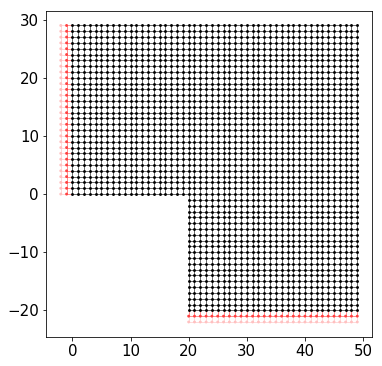

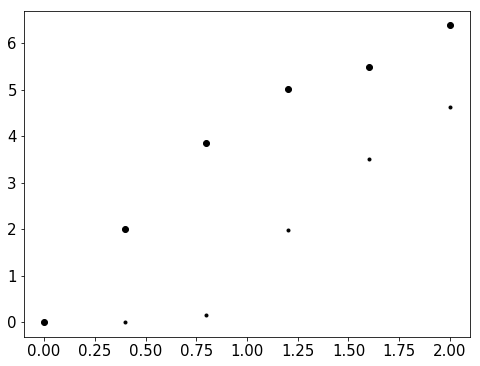

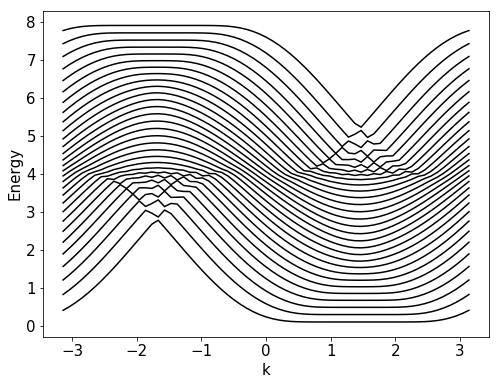

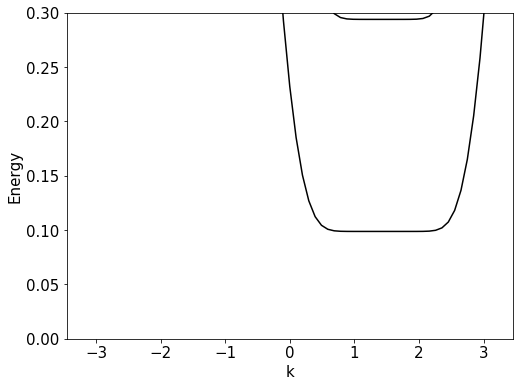

In [13]:
sys = make_bend(W=30,L=50)
kwant.plot(sys)
fig=plot_transmission(sys.finalized(), np.linspace(0, 2, 6), 0, 0.1);
fig.axes[0].set_ylim(0,0.3)
fig

# plotting the wavefunction with rough walls

In [337]:
def plot_wavefunction(syst, energy, lead, Uw, phi):
    params = SimpleNamespace(Uw=Uw, phi=phi, salt=12);
    wfs = kwant.wave_function(syst, energy, args=[params])
    density = np.sum(abs(wfs(lead))**2, axis=0)
    kwant.plotter.map(syst, density)
    

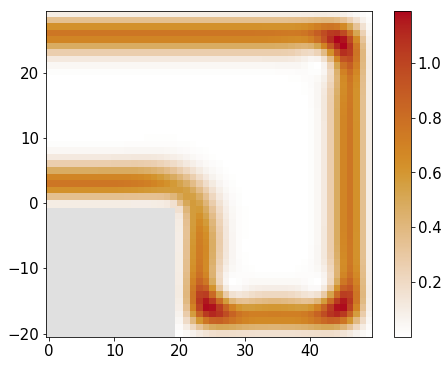

In [341]:
plot_wavefunction(sys.finalized(), energy=0.15, lead=0, Uw=0, phi=0.1)